In [1]:
!pip install pandas scikit-learn nltk

  Using cached numpy-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
  Using cached click-8.1.7-py3-none-any.whl (97 kB)


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import time

nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [2]:
file_path = r'D:\Codes\NewsClassifier\News_Category_Dataset_v3.json'
df2 = pd.read_json(file_path, lines=True)
df2['text'] = df2['headline'] + " " + df2['short_description']
df2 = df2[['category', 'text']]

{'U.S. NEWS': 1377, 'COMEDY': 5400, 'PARENTING': 8791, 'WORLD NEWS': 3299, 'CULTURE & ARTS': 1074, 'TECH': 2104, 'SPORTS': 5077, 'ENTERTAINMENT': 17362, 'POLITICS': 35602, 'WEIRD NEWS': 2777, 'ENVIRONMENT': 1444, 'EDUCATION': 1014, 'CRIME': 3562, 'SCIENCE': 2206, 'WELLNESS': 17945, 'BUSINESS': 5992, 'STYLE & BEAUTY': 9814, 'FOOD & DRINK': 6340, 'MEDIA': 2944, 'QUEER VOICES': 6347, 'HOME & LIVING': 4320, 'WOMEN': 3572, 'BLACK VOICES': 4583, 'TRAVEL': 9900, 'MONEY': 1756, 'RELIGION': 2577, 'LATINO VOICES': 1130, 'IMPACT': 3484, 'WEDDINGS': 3653, 'COLLEGE': 1144, 'PARENTS': 3955, 'ARTS & CULTURE': 1339, 'STYLE': 2254, 'GREEN': 2622, 'TASTE': 2096, 'HEALTHY LIVING': 6694, 'THE WORLDPOST': 3664, 'GOOD NEWS': 1398, 'WORLDPOST': 2579, 'FIFTY': 1401, 'ARTS': 1509, 'DIVORCE': 3426}


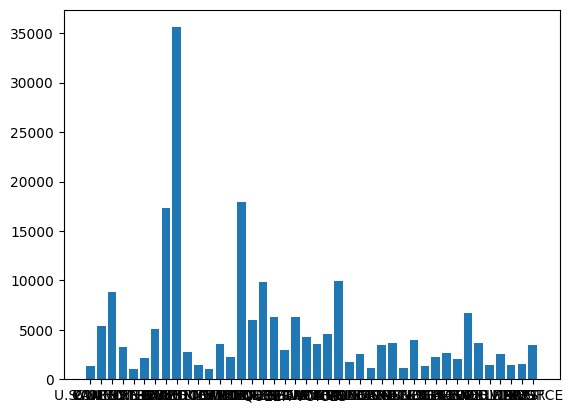

In [3]:
#issue 1 - visualising the distriubution of all classes in the dataset. 
category_count={}
for i in df2['category']:
    if i in category_count:
        category_count[i]+=1
    else:
        category_count[i]=1
print(category_count)

import matplotlib.pyplot as plt

plt.bar(range(len(category_count)), list(category_count.values()), align='center')
plt.xticks(range(len(category_count)), list(category_count.keys()))
plt.show()

In [10]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(tokens)

df2['processed_text'] = df2['text'].apply(preprocess_text)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df2['processed_text'], df2['category'], test_size=0.6)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('classifier', MultinomialNB()),
])

In [13]:
print("Training the model...")
start_time = time.time()
pipeline.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

print("Making predictions...")
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

Training the model...
Training completed in 2.57 seconds (0.04 minutes)
Making predictions...
Accuracy: 0.4934

Classification Report:
                precision    recall  f1-score   support

          ARTS       0.50      0.02      0.03       887
ARTS & CULTURE       1.00      0.00      0.00       804
  BLACK VOICES       0.64      0.06      0.11      2842
      BUSINESS       0.48      0.24      0.32      3563
       COLLEGE       0.40      0.00      0.01       678
        COMEDY       0.68      0.19      0.30      3252
         CRIME       0.53      0.44      0.49      2116
CULTURE & ARTS       1.00      0.00      0.01       635
       DIVORCE       0.87      0.43      0.57      2004
     EDUCATION       0.67      0.00      0.01       608
 ENTERTAINMENT       0.44      0.76      0.56     10440
   ENVIRONMENT       1.00      0.04      0.08       877
         FIFTY       1.00      0.00      0.00       837
  FOOD & DRINK       0.57      0.68      0.62      3770
     GOOD NEWS       0.6